In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import xgboost as xgb
import shap


# ============================================
# 1. 데이터 로드 (이미 df 있으면 이 부분은 넘어가도 됨)
# ============================================

df = pd.read_csv("일반인데이터.csv")
# print("원본 데이터 모양:", df.shape)

# 만약 위에서 이미 df를 만들었다면, 이 파일에서는 df가 있다고 가정하고 진행


# ============================================
# 2. 문자열(col dtype=object) 컬럼 드롭해서 숫자형만 남기기
# ============================================

# 문자열 컬럼 이름 리스트 추출
str_df = df.select_dtypes('object').columns.to_list()
print("문자열 컬럼 수:", len(str_df))
print("문자열 컬럼 예시:", str_df[:10])

# 문자열 컬럼 전부 드롭 → new_df는 숫자형만 남음
new_df = df.drop(columns=str_df)
print("문자열 드롭 후 데이터 모양:", new_df.shape)

c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\82104\AppData\Local\Temp\ipykernel_19036\286299569.py:15: DtypeWarning: Columns (320) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("일반인데이터.csv")


문자열 컬럼 수: 39
문자열 컬럼 예시: ['발급회원번호', '발급회원번호_01', '발급회원번호_02', '_1순위업종', '_2순위업종', '_3순위업종', '_1순위쇼핑업종', '_2순위쇼핑업종', '_3순위쇼핑업종', '_1순위교통업종']
문자열 드롭 후 데이터 모양: (48540, 859)


In [2]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 1. 윈도우 한글 폰트 경로 (예: 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"

# 2. 폰트 이름 얻어서 설정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 3. 마이너스(-) 깨지는 것도 방지
plt.rcParams['axes.unicode_minus'] = False


In [3]:
len(df)

48540

C:\Users\82104\AppData\Local\Temp\ipykernel_19036\1357696381.py:16: DtypeWarning: Columns (320) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("일반인데이터.csv",)


원본 데이터 모양: (48540, 898)
기울기 컬럼 추가 후 모양: (48540, 901)
최신 기준년월: 201812
최신 기준년월 데이터 모양: (8090, 901)

[이탈 위험 점수(Churn_Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Slope_Count  Churn_Score
46091  SYN_6996 -259949.057143  -4.660814e+05    -6.057143         65.5
42690  SYN_2794 -252282.000000  -1.153060e+05    -7.057143         59.9
44916  SYN_5559 -269313.542857  -4.408969e+04    -1.771429         45.9
43634  SYN_3956 -222279.228571  -1.688151e+05    -1.971429         42.1
44828  SYN_5455 -223850.714286  -6.172100e+04    -2.371429         41.3
47934  SYN_9236  -60932.800000  -1.319902e+06    -0.457143         37.9
48032  SYN_9371  -66425.457143  -7.836350e+05    -3.942857         37.4
43497  SYN_3788 -100427.771429  -8.815257e+05    -1.285714         37.0
46815  SYN_7870 -185475.057143  -3.622340e+04    -2.971429         36.7
45497  SYN_6254 -155607.628571  -2.336961e+05    -3.000000         36.5

[모델 학습용 데이터]
X shape: (8090, 861)
y length: 8090
X_train: (6472, 861)
X_test :


SHAP용 샘플 shape: (200, 861)


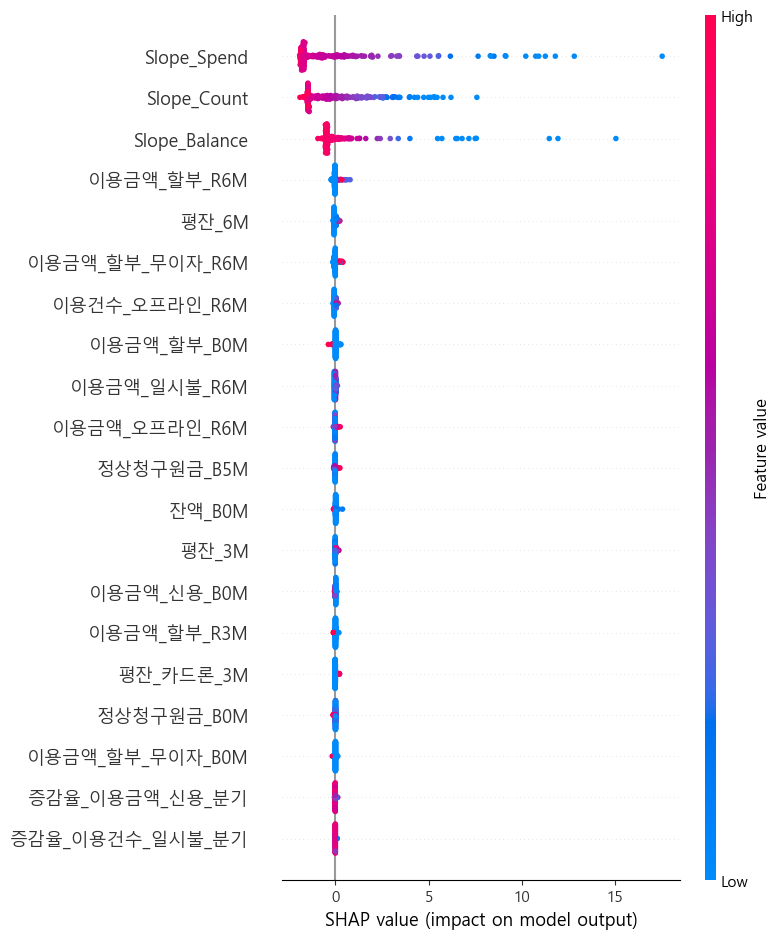

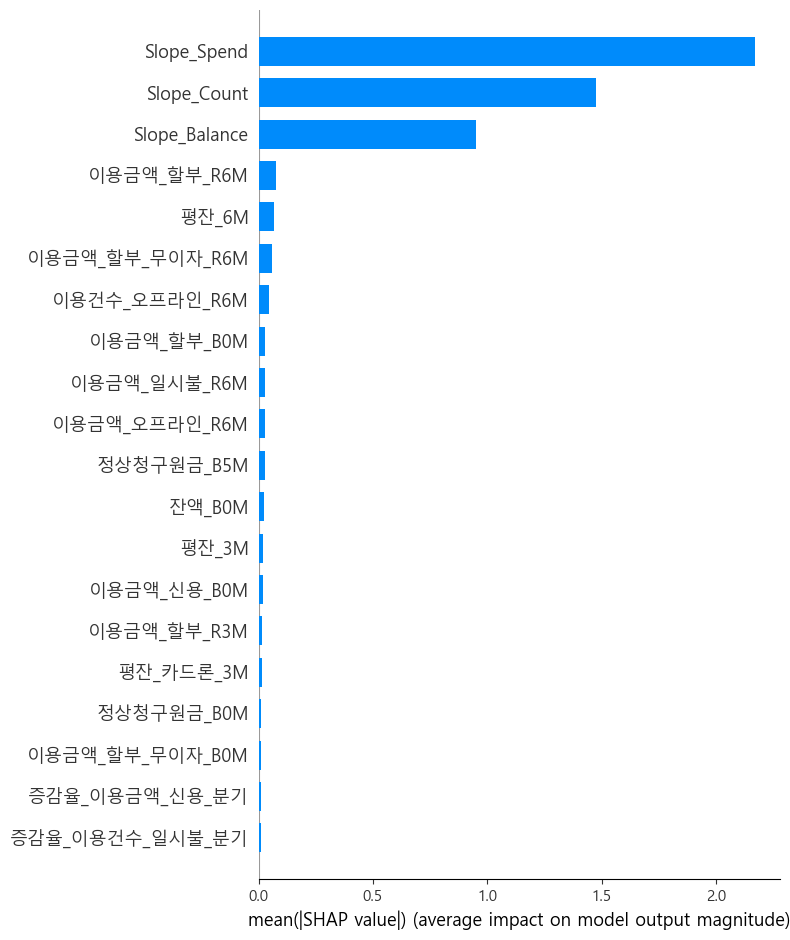

In [4]:
# ==============================
# 0. 라이브러리 불러오기
# ==============================
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap

# ==============================
# 1. 데이터 로드
# ==============================
# 경로는 네 폴더 구조에 맞게 수정
df = pd.read_csv("일반인데이터.csv",)

# 회원번호 + 기준년월 기준으로 정렬 (기울기 계산을 위해)
df = df.sort_values(by=['발급회원번호', '기준년월'])

print("원본 데이터 모양:", df.shape)

# ==============================
# 2. 6개월 기울기(Slope) 계산 함수
# ==============================
def calc_slope_6m(series):
    # 데이터가 2개 미만이거나 전부 0이면 기울기 0으로 처리
    if len(series) < 2:
        return 0
    if np.sum(series) == 0:
        return 0
    
    y = series.values
    x = np.arange(len(y))
    
    slope, _, _, _, _ = linregress(x, y)
    return slope

# ==============================
# 3. 회원별 기울기 계산 (df에 컬럼 추가)
# ==============================
# 이용금액, 잔액, 이용건수 기준 기울기
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

print("기울기 컬럼 추가 후 모양:", df.shape)

# ==============================
# 4. 현재 시점(최신 기준년월) 데이터만 추출
# ==============================
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

print("최신 기준년월:", target_month)
print("최신 기준년월 데이터 모양:", df_final.shape)

# ==============================
# 5. 기울기를 '이탈 점수용 스케일'로 변환
# ==============================
# 전략:
#   - 기울기가 음수(감소)인 경우만 위험으로 보고, 절대값을 키운다.
#   - MinMaxScaler로 0~1 사이로 정규화한다.

def convert_slope_to_score(series):
    # 감소(음수)만 추출, 나머지는 0
    # 예: -5000 -> 5000, +1000 -> 0
    negative_slopes = series.apply(lambda x: -x if x < 0 else 0)
    
    # 2차원 배열로 변환
    values = negative_slopes.values.reshape(-1, 1)
    
    # MinMax 스케일링 (0~1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    
    # 다시 1차원으로
    scaled = scaled.flatten()
    return scaled

# 각 지표별 0~1 스케일 점수
score_spend_norm = convert_slope_to_score(df_final['Slope_Spend'])
score_balance_norm = convert_slope_to_score(df_final['Slope_Balance'])
score_count_norm = convert_slope_to_score(df_final['Slope_Count'])

# ==============================
# 6. 리스크 점수 및 최종 이탈 점수 계산
# ==============================
# 가중치 (원하면 나중에 조정 가능)
W_SPEND = 40   # 소비 감소
W_BALANCE = 30 # 잔액 감소
W_COUNT = 20   # 이용 빈도 감소
W_RISK = 10    # 연체/승인거절 등 리스크

# 연체/승인거절이 있으면 리스크 1, 없으면 0
# (해당 컬럼이 없으면 0으로 처리)
risk_cond = 0

if '연체잔액_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['연체잔액_B0M'] > 0)

if '승인거절건수_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['승인거절건수_B0M'] > 0)

has_risk = np.where(risk_cond, 1, 0)

# 최종 Churn Score (0~100점 스케일 느낌)
df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) +
    (score_balance_norm * W_BALANCE) +
    (score_count_norm * W_COUNT) +
    (has_risk * W_RISK)
)

df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

# 상위 10명 출력
print("\n[이탈 위험 점수(Churn_Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))

# ==============================
# 7. XGBoost용 학습 데이터 구성
# ==============================
# 타깃: Churn_Score
y = df_final['Churn_Score']

# X 후보: 타깃, ID, 기준년월 제외
drop_cols = ['Churn_Score', '발급회원번호', '기준년월']
X = df_final.drop(columns=drop_cols, errors='ignore')

# 숫자형 컬럼만 사용 (카테고리/문자형 제외)
X = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

print("\n[모델 학습용 데이터]")
print("X shape:", X.shape)
print("y length:", len(y))

# train / test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

# ==============================
# 8. XGBoost Regressor 학습
# ==============================
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("\n[XGBoost 성능]")
print("Train R2:", model.score(X_train, y_train))
print("Test  R2:", model.score(X_test, y_test))

# ==============================
# 9. SHAP 계산 (메모리 줄이기 위해 샘플링)
# ==============================
# Jupyter에서 시각화용
shap.initjs()

# SHAP용 샘플 (행 수가 200보다 작으면 그만큼만 사용)
sample_n = min(200, len(X_train))
X_sample = X_train.sample(n=sample_n, random_state=42)

print("\nSHAP용 샘플 shape:", X_sample.shape)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# ==============================
# 10. SHAP 시각화
# ==============================
# 1) 요약 그래프 (점 그래프)
shap.summary_plot(shap_values, X_sample)

# 2) 바 형태 요약 그래프 (평균 절대값 기준 중요도)
shap.summary_plot(shap_values, X_sample, plot_type="bar")


In [5]:
# ==============================
# 0. 라이브러리 불러오기
# ==============================
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap  # <-- 이거 진짜 실행됐는지 꼭 확인

# ==============================
# 1. 데이터 로드
# ==============================
df = pd.read_csv("일반인데이터.csv")

# 회원번호 + 기준년월 기준으로 정렬
df = df.sort_values(by=['발급회원번호', '기준년월'])

print("원본 데이터 모양:", df.shape)

# ==============================
# 2. 6개월 기울기(Slope) 계산 함수
# ==============================
def calc_slope_6m(series):
    if len(series) < 2:
        return 0
    if np.sum(series) == 0:
        return 0
    
    y = series.values
    x = np.arange(len(y))
    
    slope, _, _, _, _ = linregress(x, y)
    return slope

# ==============================
# 3. 회원별 기울기 계산 (df에 컬럼 추가)
# ==============================
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

print("기울기 컬럼 추가 후 모양:", df.shape)

# ==============================
# 4. 최신 기준년월 데이터만 추출
# ==============================
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

print("최신 기준년월:", target_month)
print("최신 기준년월 데이터 모양:", df_final.shape)

# ==============================
# 5. 기울기 -> 점수 변환 함수
# ==============================
def convert_slope_to_score(series):
    negative_slopes = series.apply(lambda x: -x if x < 0 else 0)
    values = negative_slopes.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    scaled = scaled.flatten()
    return scaled

score_spend_norm = convert_slope_to_score(df_final['Slope_Spend'])
score_balance_norm = convert_slope_to_score(df_final['Slope_Balance'])
score_count_norm = convert_slope_to_score(df_final['Slope_Count'])

# ==============================
# 6. 리스크 + 최종 Churn_Score 계산
# ==============================
W_SPEND = 40
W_BALANCE = 30
W_COUNT = 20
W_RISK = 10

risk_cond = 0

if '연체잔액_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['연체잔액_B0M'] > 0)

if '승인거절건수_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['승인거절건수_B0M'] > 0)

has_risk = np.where(risk_cond, 1, 0)

df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) +
    (score_balance_norm * W_BALANCE) +
    (score_count_norm * W_COUNT) +
    (has_risk * W_RISK)
)

df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

print("\n[이탈 위험 점수(Churn_Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))

# ==============================
# 7. XGBoost용 데이터 구성
# ==============================
y = df_final['Churn_Score']

drop_cols = ['Churn_Score', '발급회원번호', '기준년월']
X = df_final.drop(columns=drop_cols, errors='ignore')
X = X.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

print("\n[모델 학습용 데이터]")
print("X shape:", X.shape)
print("y length:", len(y))

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

# ==============================
# 8. XGBoost 모델 학습
# ==============================
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("\n[XGBoost 성능]")
print("Train R2:", model.score(X_train, y_train))
print("Test  R2:", model.score(X_test, y_test))

# ==============================
# 9. SHAP 계산 (샘플링)
# ==============================
shap.initjs()

sample_n = min(200, len(X_train))
X_sample = X_train.sample(n=sample_n, random_state=42)

print("\nSHAP용 샘플 shape:", X_sample.shape)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# ==============================
# 10. SHAP 지수 0인 컬럼 제거
# ==============================
shap_importance = np.abs(shap_values).mean(axis=0)
shap_importance = pd.Series(shap_importance, index=X_sample.columns)

zero_shap_cols = shap_importance[shap_importance == 0].index.tolist()

print("\n[SHAP 지수 0인 컬럼]")
print("개수:", len(zero_shap_cols))
print("일부 예시:", zero_shap_cols[:20])

X_train_reduced = X_train.drop(columns=zero_shap_cols, errors='ignore')
X_test_reduced  = X_test.drop(columns=zero_shap_cols, errors='ignore')

print("\n[SHAP 0 컬럼 제거 후 데이터]")
print("X_train_reduced:", X_train_reduced.shape)
print("X_test_reduced :", X_test_reduced.shape)

# (원하면 여기서 모델 다시 학습)
# model.fit(X_train_reduced, y_train)
# print("Reduced Test R2:", model.score(X_test_reduced, y_test))


C:\Users\82104\AppData\Local\Temp\ipykernel_19036\1797960323.py:15: DtypeWarning: Columns (320) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("일반인데이터.csv")


원본 데이터 모양: (48540, 898)
기울기 컬럼 추가 후 모양: (48540, 901)
최신 기준년월: 201812
최신 기준년월 데이터 모양: (8090, 901)

[이탈 위험 점수(Churn_Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Slope_Count  Churn_Score
46091  SYN_6996 -259949.057143  -4.660814e+05    -6.057143         65.5
42690  SYN_2794 -252282.000000  -1.153060e+05    -7.057143         59.9
44916  SYN_5559 -269313.542857  -4.408969e+04    -1.771429         45.9
43634  SYN_3956 -222279.228571  -1.688151e+05    -1.971429         42.1
44828  SYN_5455 -223850.714286  -6.172100e+04    -2.371429         41.3
47934  SYN_9236  -60932.800000  -1.319902e+06    -0.457143         37.9
48032  SYN_9371  -66425.457143  -7.836350e+05    -3.942857         37.4
43497  SYN_3788 -100427.771429  -8.815257e+05    -1.285714         37.0
46815  SYN_7870 -185475.057143  -3.622340e+04    -2.971429         36.7
45497  SYN_6254 -155607.628571  -2.336961e+05    -3.000000         36.5

[모델 학습용 데이터]
X shape: (8090, 861)
y length: 8090
X_train: (6472, 861)
X_test :


SHAP용 샘플 shape: (200, 861)

[SHAP 지수 0인 컬럼]
개수: 491
일부 예시: ['컨택건수_리볼빙_TM_B0M', '컨택건수_CA_TM_B0M', '컨택건수_신용발급_TM_B0M', '컨택건수_부대서비스_TM_B0M', '컨택건수_포인트소진_TM_B0M', '컨택건수_보험_TM_B0M', '컨택건수_카드론_LMS_B0M', '컨택건수_CA_LMS_B0M', '컨택건수_리볼빙_LMS_B0M', '컨택건수_카드론_EM_B0M', '컨택건수_CA_EM_B0M', '컨택건수_리볼빙_EM_B0M', '컨택건수_카드론_청구서_B0M', '컨택건수_리볼빙_청구서_B0M', '컨택건수_카드론_인터넷_B0M', '컨택건수_CA_인터넷_B0M', '컨택건수_리볼빙_인터넷_B0M', '컨택건수_카드론_당사앱_B0M', '컨택건수_CA_당사앱_B0M', '컨택건수_리볼빙_당사앱_B0M']

[SHAP 0 컬럼 제거 후 데이터]
X_train_reduced: (6472, 370)
X_test_reduced : (1618, 370)


In [6]:
# ==============================
# 11. SHAP 0 컬럼 제거된 데이터 CSV로 저장
# ==============================

# 1) 최신 기준년월 전체 데이터(df_final)에서 0 SHAP 컬럼 제거한 버전
df_final_reduced = df_final.drop(columns=zero_shap_cols, errors='ignore')

# 엑셀에서 깨지지 않게 utf-8-sig로 저장
df_final_reduced.to_csv("일반인데이터_SHAP0제거_full.csv",
                        index=False,
                        encoding="utf-8-sig")

# 2) 학습/테스트용 X도 따로 저장하고 싶으면
X_train_reduced.to_csv("일반인데이터_SHAP0제거_X_train.csv",
                       index=False,
                       encoding="utf-8-sig")

X_test_reduced.to_csv("일반인데이터_SHAP0제거_X_test.csv",
                      index=False,
                      encoding="utf-8-sig")

print("\nCSV 저장 완료:")
print(" - 일반인데이터_SHAP0제거_full.csv")
print(" - 일반인데이터_SHAP0제거_X_train.csv")
print(" - 일반인데이터_SHAP0제거_X_test.csv")



CSV 저장 완료:
 - 일반인데이터_SHAP0제거_full.csv
 - 일반인데이터_SHAP0제거_X_train.csv
 - 일반인데이터_SHAP0제거_X_test.csv


In [7]:
import pandas as pd

# 1) SHAP feature importance 파일 불러오기 (파일 이름 맞게 바꿔)
imp = pd.read_csv("shap_feature_importance.csv", index_col=0)

# 2) 숫자 값이 들어있는 첫 번째 컬럼 이름 가져오기
value_col = imp.columns[0]

# 3) 중요도가 0이 아닌 피처만 남기기
imp_nonzero = imp[imp[value_col] != 0]

# 4) 새 CSV로 저장
imp_nonzero.to_csv("shap_feature_importance_nonzero.csv",
                   encoding="utf-8-sig")


In [8]:
# -------------------------------------------------------
# 5. VIF 계산을 위한 데이터 준비
# -------------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) df_final에서 숫자형 컬럼만 추출 (타깃과 ID, 기준년월은 제외)
exclude_cols = ['발급회원번호', '기준년월', 'Churn_Score']
numeric_df = df_final.drop(columns=exclude_cols, errors='ignore')
numeric_df = numeric_df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).copy()

print("\n[숫자형 변수 개수 확인]")
print("numeric_df shape:", numeric_df.shape)

# -------------------------------------------------------
# 6. VIF를 계산할 피처 리스트 정의
#    (가이드라인에서 준 컬럼들 그대로 사용)
# -------------------------------------------------------
features = [
    '연속무실적개월수_기본_24M_카드', '회원여부_이용가능', '증감율_이용금액_신용_전월', '연체잔액_B0M',
    '이용후경과월_신용', '이용후경과월_신판', '이용개월수_신용_R6M', '이용개월수_신판_R6M',
    '이용개월수_일시불_R6M', '이용개월수_오프라인_R6M', '이용개월수_신용_R3M', '이용개월수_신판_R3M',
    '이용개월수_일시불_R3M', '이용개월수_신용_R12M', '이용개월수_신판_R12M', '이용개월수_일시불_R12M',
    '이용개월수_전체_R6M', '이용개월수_전체_R3M', '청구서발송여부_R6M', '청구서발송여부_R3M',
    '이용개월수_결제일_R6M', '이용후경과월_일시불', '청구서발송여부_B0', '이용개월수_결제일_R3M',
    '이용카드수_신용', '연속유실적개월수_기본_24M_카드', '상환개월수_결제일_R3M', '상환개월수_결제일_R6M',
    '이용카드수_신용체크', '증감율_이용금액_신판_전월', 'RP후경과월', '증감율_이용금액_일시불_전월',
    '회원여부_이용가능_CA', '이용여부_3M_해외겸용_신용_본인'
]

# numeric_df에 실제 존재하는 컬럼만 사용 (혹시 빠진 게 있으면 자동 필터)
features_in_df = [col for col in features if col in numeric_df.columns]

print("\n[VIF 대상 초기 피처 개수]")
print(len(features_in_df))
print(features_in_df)

# VIF 계산용 X 데이터셋
X = numeric_df[features_in_df].copy()
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# -------------------------------------------------------
# 7. Stepwise VIF 제거 루프
# -------------------------------------------------------
vif_threshold = 10  # 기준값

print(f"\n--- VIF {vif_threshold} 기준 변수 최적화 시작 ---")

while True:
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    
    # 현재 가장 큰 VIF 찾기
    max_vif = vif_data['VIF'].max()
    max_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']
    
    print(f"\n현재 최대 VIF: {max_vif:.2f} ({max_feature})")
    
    # 기준 초과면 해당 변수 제거 후 다시 반복
    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})")
        X = X.drop(columns=[max_feature])
    else:
        # 모든 VIF가 기준 이하이면 종료
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===")
        print(vif_data.sort_values(by='VIF', ascending=False))
        break

# -------------------------------------------------------
# 8. 최종 선택된 피처 리스트 출력 및 저장
# -------------------------------------------------------
final_features = list(X.columns)

print(f"\n최종 선택된 피처 개수: {len(final_features)}")
print("최종 피처 리스트:")
print(final_features)

# 필요하면 CSV로 저장
vif_result = pd.DataFrame({
    "feature": final_features
})
vif_result.to_csv("VIF_최종_선택변수리스트.csv", index=False, encoding="utf-8-sig")
print("\n[VIF 결과 저장 완료] → VIF_최종_선택변수리스트.csv")



[숫자형 변수 개수 확인]
numeric_df shape: (8090, 861)

[VIF 대상 초기 피처 개수]
34
['연속무실적개월수_기본_24M_카드', '회원여부_이용가능', '증감율_이용금액_신용_전월', '연체잔액_B0M', '이용후경과월_신용', '이용후경과월_신판', '이용개월수_신용_R6M', '이용개월수_신판_R6M', '이용개월수_일시불_R6M', '이용개월수_오프라인_R6M', '이용개월수_신용_R3M', '이용개월수_신판_R3M', '이용개월수_일시불_R3M', '이용개월수_신용_R12M', '이용개월수_신판_R12M', '이용개월수_일시불_R12M', '이용개월수_전체_R6M', '이용개월수_전체_R3M', '청구서발송여부_R6M', '청구서발송여부_R3M', '이용개월수_결제일_R6M', '이용후경과월_일시불', '청구서발송여부_B0', '이용개월수_결제일_R3M', '이용카드수_신용', '연속유실적개월수_기본_24M_카드', '상환개월수_결제일_R3M', '상환개월수_결제일_R6M', '이용카드수_신용체크', '증감율_이용금액_신판_전월', 'RP후경과월', '증감율_이용금액_일시불_전월', '회원여부_이용가능_CA', '이용여부_3M_해외겸용_신용_본인']

--- VIF 10 기준 변수 최적화 시작 ---


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 4580.72 (이용개월수_신판_R6M)
제거됨: 이용개월수_신판_R6M (VIF: 4580.72)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 1730.02 (이용개월수_일시불_R3M)
제거됨: 이용개월수_일시불_R3M (VIF: 1730.02)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 1027.46 (이용개월수_신판_R12M)
제거됨: 이용개월수_신판_R12M (VIF: 1027.46)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 894.04 (이용개월수_신용_R3M)
제거됨: 이용개월수_신용_R3M (VIF: 894.04)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 490.50 (이용개월수_일시불_R6M)
제거됨: 이용개월수_일시불_R6M (VIF: 490.50)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 474.21 (이용개월수_신용_R12M)
제거됨: 이용개월수_신용_R12M (VIF: 474.21)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 446.44 (이용개월수_전체_R3M)
제거됨: 이용개월수_전체_R3M (VIF: 446.44)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 255.70 (이용개월수_신용_R6M)
제거됨: 이용개월수_신용_R6M (VIF: 255.70)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 164.90 (이용개월수_결제일_R6M)
제거됨: 이용개월수_결제일_R6M (VIF: 164.90)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 90.66 (청구서발송여부_R3M)
제거됨: 청구서발송여부_R3M (VIF: 90.66)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 80.59 (상환개월수_결제일_R3M)
제거됨: 상환개월수_결제일_R3M (VIF: 80.59)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 72.22 (이용후경과월_신판)
제거됨: 이용후경과월_신판 (VIF: 72.22)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 67.46 (이용개월수_전체_R6M)
제거됨: 이용개월수_전체_R6M (VIF: 67.46)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 50.22 (이용개월수_일시불_R12M)
제거됨: 이용개월수_일시불_R12M (VIF: 50.22)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 41.85 (증감율_이용금액_신판_전월)
제거됨: 증감율_이용금액_신판_전월 (VIF: 41.85)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 31.10 (청구서발송여부_B0)
제거됨: 청구서발송여부_B0 (VIF: 31.10)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 26.84 (이용개월수_신판_R3M)
제거됨: 이용개월수_신판_R3M (VIF: 26.84)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 23.70 (이용개월수_결제일_R3M)
제거됨: 이용개월수_결제일_R3M (VIF: 23.70)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 21.40 (회원여부_이용가능)
제거됨: 회원여부_이용가능 (VIF: 21.40)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 21.33 (이용카드수_신용)
제거됨: 이용카드수_신용 (VIF: 21.33)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



현재 최대 VIF: 13.78 (청구서발송여부_R6M)
제거됨: 청구서발송여부_R6M (VIF: 13.78)

현재 최대 VIF: 9.72 (이용개월수_오프라인_R6M)

=== 최적화 완료 (모든 VIF <= 10) ===
               feature       VIF
4       이용개월수_오프라인_R6M  9.721494
10     증감율_이용금액_일시불_전월  9.399411
1       증감율_이용금액_신용_전월  9.224605
11        회원여부_이용가능_CA  7.031714
7        상환개월수_결제일_R6M  6.915990
6   연속유실적개월수_기본_24M_카드  5.594505
3            이용후경과월_신용  4.947684
8           이용카드수_신용체크  4.643597
0   연속무실적개월수_기본_24M_카드  3.451594
9               RP후경과월  3.223213
12  이용여부_3M_해외겸용_신용_본인  2.886397
5           이용후경과월_일시불  2.656933
2             연체잔액_B0M       NaN

최종 선택된 피처 개수: 13
최종 피처 리스트:
['연속무실적개월수_기본_24M_카드', '증감율_이용금액_신용_전월', '연체잔액_B0M', '이용후경과월_신용', '이용개월수_오프라인_R6M', '이용후경과월_일시불', '연속유실적개월수_기본_24M_카드', '상환개월수_결제일_R6M', '이용카드수_신용체크', 'RP후경과월', '증감율_이용금액_일시불_전월', '회원여부_이용가능_CA', '이용여부_3M_해외겸용_신용_본인']

[VIF 결과 저장 완료] → VIF_최종_선택변수리스트.csv


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [9]:
# -------------------------------------------------------
# 5. VIF 계산을 위한 데이터 준비 (전체 숫자 컬럼 대상)
# -------------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 1) df_final에서 ID, 기준년월, 타깃(Churn_Score) 제외
exclude_cols = ['발급회원번호', '기준년월', 'Churn_Score']
numeric_df = df_final.drop(columns=exclude_cols, errors='ignore')

# 2) 숫자형 컬럼만 사용
numeric_df = numeric_df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).copy()

print("\n[전체 숫자형 변수 개수 확인]")
print("numeric_df shape:", numeric_df.shape)
print("사용 컬럼 수:", len(numeric_df.columns))

# 3) NaN → 0, 형변환 (혹시 모를 에러 방지)
X = numeric_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# -------------------------------------------------------
# 6. 전체 컬럼 대상 Stepwise VIF 제거
# -------------------------------------------------------
vif_threshold = 10  # 기준값
step = 0

print(f"\n--- 전체 숫자 컬럼 기준 VIF {vif_threshold} 최적화 시작 ---")

while True:
    step += 1
    print(f"\n[STEP {step}] 현재 피처 수: {X.shape[1]}")

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]

    # 현재 최대 VIF 찾기
    max_vif = vif_data['VIF'].max()
    max_feature = vif_data.loc[vif_data['VIF'].idxmax(), 'feature']

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})")

    # 기준 초과면 해당 변수 제거 후 다시 반복
    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})")
        X = X.drop(columns=[max_feature])
    else:
        # 모든 VIF가 기준 이하이면 종료
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===")
        print(vif_data.sort_values(by='VIF', ascending=False))
        break

# -------------------------------------------------------
# 7. 최종 선택된 피처 리스트 출력 및 저장
# -------------------------------------------------------
final_features = list(X.columns)

print(f"\n[최종 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}")
print("최종 피처 리스트:")
print(final_features)

# 최종 VIF 테이블 저장
vif_final_table = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)

vif_final_table.to_csv("VIF_전체컬럼_최종결과.csv", index=False, encoding="utf-8-sig")

# 최종 살아남은 피처 리스트만 따로 저장
pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_전체컬럼_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_전체컬럼_최종결과.csv")
print(" - VIF_전체컬럼_최종_선택변수리스트.csv")



[전체 숫자형 변수 개수 확인]
numeric_df shape: (8090, 861)
사용 컬럼 수: 861

--- 전체 숫자 컬럼 기준 VIF 10 최적화 시작 ---

[STEP 1] 현재 피처 수: 861


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용건수_신용_B0M)
제거됨: 이용건수_신용_B0M (VIF: inf)

[STEP 2] 현재 피처 수: 860


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용건수_신판_B0M)
제거됨: 이용건수_신판_B0M (VIF: inf)

[STEP 3] 현재 피처 수: 859


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용건수_할부_B0M)
제거됨: 이용건수_할부_B0M (VIF: inf)

[STEP 4] 현재 피처 수: 858


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용금액_신용_B0M)
제거됨: 이용금액_신용_B0M (VIF: inf)

[STEP 5] 현재 피처 수: 857


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

In [10]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ============================================
# 0. VIF에서 제외할 컬럼들 설정
#    (타깃 + 타깃 만들 때 쓴 컬럼들 + ID/기준년월)
# ============================================
target_col = 'Churn_Score'

target_related_cols = [
    'Slope_Spend',
    'Slope_Balance',
    'Slope_Count',
    '연체잔액_B0M',
    '승인거절건수_B0M'
]

id_time_cols = ['발급회원번호', '기준년월']

exclude_cols_for_vif = [target_col] + target_related_cols + id_time_cols

# ============================================
# 1. VIF용 전체 숫자 컬럼 데이터 만들기
#    (df_final에서 제외 컬럼 빼고, 숫자형만)
# ============================================
df_vif_base = df_final.drop(columns=exclude_cols_for_vif, errors='ignore')
df_vif_base = df_vif_base.select_dtypes(
    include=['int64', 'float64', 'int32', 'float32']
).copy()

print("\n[전체 VIF 후보 데이터]")
print("shape:", df_vif_base.shape)
print("컬럼 수:", len(df_vif_base.columns), flush=True)

# ============================================
# 2. 층화추출을 위한 Churn_Score 구간화(binning)
# ============================================
churn_values = df_final[target_col].values

# Churn_Score가 0~100 사이라고 가정하고 5구간으로 자름
bins = [-0.1, 20, 40, 60, 80, 100.1]
labels = [0, 1, 2, 3, 4]

churn_bins = pd.cut(churn_values, bins=bins, labels=labels)

# bin이 NaN인 행은 제외
mask_valid = ~pd.isna(churn_bins)
df_vif_base_valid = df_vif_base[mask_valid].copy()
churn_bins_valid = churn_bins[mask_valid]

print("\n[층화 대상 행 개수]")
print("유효 행 수:", len(df_vif_base_valid), flush=True)

# ============================================
# 3. 층화추출로 2,000행 샘플링
#    (Churn_Score 분포 비슷하게 유지)
# ============================================
sample_size = 2000

if len(df_vif_base_valid) <= sample_size:
    print("\n⚠ 유효 행이 2000개 이하라서, 전체 행을 그대로 사용합니다.", flush=True)
    X_sample = df_vif_base_valid.copy()
else:
    try:
        X_sample, _, bins_sample, _ = train_test_split(
            df_vif_base_valid,
            churn_bins_valid,
            train_size=sample_size,
            stratify=churn_bins_valid,
            random_state=42
        )
        print("\n[층화 샘플링 완료]")
        print("샘플 행 수:", len(X_sample))
        print("층별 개수(샘플 기준):")
        print(pd.Series(bins_sample).value_counts().sort_index(), flush=True)
    except ValueError as e:
        # 층화가 실패하면(어떤 bin에 샘플 너무 적을 때) 그냥 랜덤 샘플링으로 fallback
        print("\n⚠ 층화 샘플링 실패, 일반 랜덤 샘플링으로 대체합니다.")
        print("에러 메시지:", e, flush=True)
        X_sample = df_vif_base_valid.sample(n=sample_size, random_state=42)

# NaN → 0
X_sample = X_sample.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\n[VIF용 샘플 데이터 최종 shape]:", X_sample.shape, flush=True)

# ============================================
# 4. 샘플 2000행 기준 Stepwise VIF 제거
#    (진행상황 로그 빡세게 찍기)
# ============================================
vif_threshold = 10
step = 0

X_vif = X_sample.copy()

start = time.time()
print(f"\n--- 샘플 2000행 기준 VIF {vif_threshold} 최적화 시작 ---", flush=True)

while True:
    step = step + 1
    print(f"\n[STEP {step}] 현재 피처 수: {X_vif.shape[1]}", flush=True)

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    vif_list = []
    for i in range(X_vif.shape[1]):
        vif_val = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_val)
    vif_data["VIF"] = vif_list

    # 현재 최대 VIF
    max_vif = vif_data["VIF"].max()
    max_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})", flush=True)

    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})", flush=True)
        X_vif = X_vif.drop(columns=[max_feature])
    else:
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===", flush=True)
        print(vif_data.sort_values(by="VIF", ascending=False), flush=True)
        break

end = time.time()
print(f"\nVIF 수행 시간(초): {end - start:.2f}", flush=True)

# ============================================
# 5. 최종 선택 피처 리스트 + 전체 데이터에 적용
# ============================================
final_features = list(X_vif.columns)

print(f"\n[최종 VIF 통과 피처 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}", flush=True)
print("최종 피처 리스트:")
print(final_features, flush=True)

# 전체 df_vif_base에서 이 컬럼들만 사용하고 싶으면:
X_full_final = df_vif_base[final_features].copy()

# CSV로 피처 리스트 저장
pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_샘플2000_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_샘플2000_최종_선택변수리스트.csv", flush=True)



[전체 VIF 후보 데이터]
shape: (8090, 856)
컬럼 수: 856

[층화 대상 행 개수]
유효 행 수: 8090

⚠ 층화 샘플링 실패, 일반 랜덤 샘플링으로 대체합니다.
에러 메시지: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

[VIF용 샘플 데이터 최종 shape]: (2000, 856)

--- 샘플 2000행 기준 VIF 10 최적화 시작 ---

[STEP 1] 현재 피처 수: 856


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


KeyboardInterrupt: 

In [13]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ============================================
# 0. VIF에서 제외할 컬럼들 설정
#    - 타깃 + 타깃 만들 때 직접 쓴 컬럼 + ID/기준년월
# ============================================
target_col = 'Churn_Score'

target_related_cols = [
    'Slope_Spend',
    'Slope_Balance',
    'Slope_Count',
    '연체잔액_B0M',
    '승인거절건수_B0M'
]

id_time_cols = ['발급회원번호', '기준년월']

exclude_cols_for_vif = [target_col] + target_related_cols + id_time_cols

# ============================================
# 1. VIF용 전체 숫자 컬럼 데이터 만들기
# ============================================
df_vif_base = df_final.drop(columns=exclude_cols_for_vif, errors='ignore')

# 숫자형만 사용
df_vif_base = df_vif_base.select_dtypes(
    include=['int64', 'float64', 'int32', 'float32']
).copy()

print("\n[전체 VIF 후보 데이터]")
print("shape:", df_vif_base.shape)
print("컬럼 수:", len(df_vif_base.columns), flush=True)

# ============================================
# 2. 층화추출용 Churn_Score 구간화 (qcut)
#    → 데이터 분포 기준으로 5등분 (0~4 레이블)
# ============================================
churn_values = df_final[target_col].values

# qcut으로 자동 등분 (중복 경계는 drop)
churn_bins = pd.qcut(churn_values, q=5, labels=False, duplicates='drop')

# df_vif_base와 strata(층) 합치기
vif_df = df_vif_base.copy()
vif_df['strata'] = churn_bins

# strata가 NaN인 행 제거
vif_df = vif_df.dropna(subset=['strata'])

# 정수형으로 변환
vif_df['strata'] = vif_df['strata'].astype(int)

print("\n[층화 대상 데이터]")
print("행 수:", len(vif_df))
print("층별 전체 개수:")
print(vif_df['strata'].value_counts().sort_index(), flush=True)

# ============================================
# 3. 층화추출로 정확히 2000행 샘플링
#    - 각 strata 비율에 맞게 나눠서 뽑고
#    - 마지막에 합계가 딱 2000이 되도록 조정
# ============================================
total_rows = len(vif_df)
target_n = 2000

# 만약 전체 행이 2000보다 적으면 → 그냥 전체 사용
if total_rows <= target_n:
    print("\n⚠ 유효 행이 2000개 이하라서, 전체 행을 그대로 사용합니다.", flush=True)
    sampled_df = vif_df.copy()
else:
    # strata별 개수/비율 계산
    strata_counts = vif_df['strata'].value_counts().sort_index()
    strata_props = strata_counts / total_rows

    # 1차 배분: 비율대로 round
    alloc = (strata_props * target_n).round().astype(int)

    # 각 strata는 최소 1개는 갖도록(전체 행이 충분하다고 가정)
    alloc[alloc < 1] = 1

    # 합계를 2000으로 맞추기 위한 조정
    diff = alloc.sum() - target_n

    # 합계가 너무 크면(>2000) → 큰 쪽 strata에서 하나씩 빼기
    while diff > 0:
        # alloc이 1보다 큰 strata 중에서, 현재 샘플 배정이 많은 순으로 정렬
        candidates = alloc[alloc > 1].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] > 1:
                alloc[idx] -= 1
                diff -= 1

    # 합계가 너무 작으면(<2000) → 여유 있는 strata에서 하나씩 추가
    while diff < 0:
        candidates = alloc[alloc < strata_counts].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] < strata_counts[idx]:
                alloc[idx] += 1
                diff += 1

    print("\n[층별 샘플 배정 개수]")
    print(alloc, flush=True)
    print("배정 합계:", alloc.sum(), flush=True)

    # 실제 층화추출 수행 (각 strata에서 alloc[strata] 만큼 랜덤 샘플)
    sampled_list = []
    for s, n_take in alloc.items():
        group = vif_df[vif_df['strata'] == s]
        n_take = int(min(n_take, len(group)))
        sampled_group = group.sample(n=n_take, random_state=42)
        sampled_list.append(sampled_group)

    sampled_df = pd.concat(sampled_list, axis=0)

    # 혹시라도 합계가 2000이 안 맞으면(이론적으로는 맞게 되어있지만), 다시 맞춰줌
    if len(sampled_df) > target_n:
        sampled_df = sampled_df.sample(n=target_n, random_state=42)
    elif len(sampled_df) < target_n:
        # 부족하면 전체에서 조금 더 랜덤 추출해서 채우기 (층 비율 비슷하게 유지됨)
        remain_n = target_n - len(sampled_df)
        remain_pool = vif_df.drop(index=sampled_df.index)
        extra = remain_pool.sample(n=remain_n, random_state=42)
        sampled_df = pd.concat([sampled_df, extra], axis=0)

print("\n[최종 층화 샘플링 결과]")
print("샘플 행 수:", len(sampled_df))
print("샘플 층별 개수:")
print(sampled_df['strata'].value_counts().sort_index(), flush=True)

# strata 컬럼은 VIF 계산에 필요 없으므로 제거
X_sample = sampled_df.drop(columns=['strata'])

# NaN → 0
X_sample = X_sample.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\n[VIF용 샘플 데이터 최종 shape]:", X_sample.shape, flush=True)

# ============================================
# 4. 샘플 2000행 기준 Stepwise VIF 제거
#    - 진행상황 전부 찍기
# ============================================
vif_threshold = 10
step = 0

X_vif = X_sample.copy()

start = time.time()
print(f"\n--- 샘플 2000행 기준 VIF {vif_threshold} 최적화 시작 ---", flush=True)

while True:
    step += 1
    print(f"\n[STEP {step}] 현재 피처 수: {X_vif.shape[1]}", flush=True)

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    vif_list = []
    for i in range(X_vif.shape[1]):
        vif_val = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_val)
    vif_data["VIF"] = vif_list

    max_vif = vif_data["VIF"].max()
    max_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})", flush=True)

    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})", flush=True)
        X_vif = X_vif.drop(columns=[max_feature])
    else:
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===", flush=True)
        print(vif_data.sort_values(by="VIF", ascending=False), flush=True)
        break

end = time.time()
print(f"\nVIF 수행 시간(초): {end - start:.2f}", flush=True)

# ============================================
# 5. 최종 선택 피처 리스트 + 전체 데이터에 적용
# ============================================
final_features = list(X_vif.columns)

print(f"\n[최종 VIF 통과 피처 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}", flush=True)
print("최종 피처 리스트:")
print(final_features, flush=True)

# 전체 데이터(df_vif_base)에서 이 컬럼들만 사용하고 싶으면:
X_full_final = df_vif_base[final_features].copy()

# 최종 피처 리스트 CSV로 저장
pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_샘플2000_층화_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_샘플2000_층화_최종_선택변수리스트.csv", flush=True)



[전체 VIF 후보 데이터]
shape: (8090, 856)
컬럼 수: 856

[층화 대상 데이터]
행 수: 8090
층별 전체 개수:
strata
0    3286
1    1574
2    1626
3    1604
Name: count, dtype: int64

[층별 샘플 배정 개수]
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64
배정 합계: 2000

[최종 층화 샘플링 결과]
샘플 행 수: 2000
샘플 층별 개수:
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64

[VIF용 샘플 데이터 최종 shape]: (2000, 856)

--- 샘플 2000행 기준 VIF 10 최적화 시작 ---

[STEP 1] 현재 피처 수: 856


KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ============================================
# 0. VIF에서 제외할 컬럼들 설정
#    - 타깃 + 타깃 만들 때 직접 쓴 컬럼 + ID/기준년월
# ============================================
target_col = 'Churn_Score'

target_related_cols = [
    'Slope_Spend',
    'Slope_Balance',
    'Slope_Count',
    '연체잔액_B0M',
    '승인거절건수_B0M'
]

id_time_cols = ['발급회원번호', '기준년월']

exclude_cols_for_vif = [target_col] + target_related_cols + id_time_cols

# ============================================
# 1. VIF용 전체 숫자 컬럼 데이터 만들기
# ============================================
df_vif_base = df_final.drop(columns=exclude_cols_for_vif, errors='ignore')

# 숫자형만 사용
df_vif_base = df_vif_base.select_dtypes(
    include=['int64', 'float64', 'int32', 'float32']
).copy()

print("\n[전체 VIF 후보 데이터]")
print("shape:", df_vif_base.shape)
print("컬럼 수:", len(df_vif_base.columns), flush=True)

# ============================================
# 2. 층화추출용 Churn_Score 구간화 (qcut)
#    → 데이터 분포 기준으로 5등분 (0~4 레이블)
# ============================================
churn_values = df_final[target_col].values

# qcut으로 자동 등분 (중복 경계는 drop)
churn_bins = pd.qcut(churn_values, q=5, labels=False, duplicates='drop')

# df_vif_base와 strata(층) 합치기
vif_df = df_vif_base.copy()
vif_df['strata'] = churn_bins

# strata가 NaN인 행 제거
vif_df = vif_df.dropna(subset=['strata'])

# 정수형으로 변환
vif_df['strata'] = vif_df['strata'].astype(int)

print("\n[층화 대상 데이터]")
print("행 수:", len(vif_df))
print("층별 전체 개수:")
print(vif_df['strata'].value_counts().sort_index(), flush=True)

# ============================================
# 3. 층화추출로 정확히 2000행 샘플링
#    - 각 strata 비율에 맞게 나눠서 뽑고
#    - 마지막에 합계가 딱 2000이 되도록 조정
# ============================================
total_rows = len(vif_df)
target_n = 2000

# 만약 전체 행이 2000보다 적으면 → 그냥 전체 사용
if total_rows <= target_n:
    print("\n⚠ 유효 행이 2000개 이하라서, 전체 행을 그대로 사용합니다.", flush=True)
    sampled_df = vif_df.copy()
else:
    # strata별 개수/비율 계산
    strata_counts = vif_df['strata'].value_counts().sort_index()
    strata_props = strata_counts / total_rows

    # 1차 배분: 비율대로 round
    alloc = (strata_props * target_n).round().astype(int)

    # 각 strata는 최소 1개는 갖도록(전체 행이 충분하다고 가정)
    alloc[alloc < 1] = 1

    # 합계를 2000으로 맞추기 위한 조정
    diff = alloc.sum() - target_n

    # 합계가 너무 크면(>2000) → 큰 쪽 strata에서 하나씩 빼기
    while diff > 0:
        # alloc이 1보다 큰 strata 중에서, 현재 샘플 배정이 많은 순으로 정렬
        candidates = alloc[alloc > 1].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] > 1:
                alloc[idx] -= 1
                diff -= 1

    # 합계가 너무 작으면(<2000) → 여유 있는 strata에서 하나씩 추가
    while diff < 0:
        candidates = alloc[alloc < strata_counts].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] < strata_counts[idx]:
                alloc[idx] += 1
                diff += 1

    print("\n[층별 샘플 배정 개수]")
    print(alloc, flush=True)
    print("배정 합계:", alloc.sum(), flush=True)

    # 실제 층화추출 수행 (각 strata에서 alloc[strata] 만큼 랜덤 샘플)
    sampled_list = []
    for s, n_take in alloc.items():
        group = vif_df[vif_df['strata'] == s]
        n_take = int(min(n_take, len(group)))
        sampled_group = group.sample(n=n_take, random_state=42)
        sampled_list.append(sampled_group)

    sampled_df = pd.concat(sampled_list, axis=0)

    # 혹시라도 합계가 2000이 안 맞으면(이론적으로는 맞게 되어있지만), 다시 맞춰줌
    if len(sampled_df) > target_n:
        sampled_df = sampled_df.sample(n=target_n, random_state=42)
    elif len(sampled_df) < target_n:
        # 부족하면 전체에서 조금 더 랜덤 추출해서 채우기 (층 비율 비슷하게 유지됨)
        remain_n = target_n - len(sampled_df)
        remain_pool = vif_df.drop(index=sampled_df.index)
        extra = remain_pool.sample(n=remain_n, random_state=42)
        sampled_df = pd.concat([sampled_df, extra], axis=0)

print("\n[최종 층화 샘플링 결과]")
print("샘플 행 수:", len(sampled_df))
print("샘플 층별 개수:")
print(sampled_df['strata'].value_counts().sort_index(), flush=True)

# strata 컬럼은 VIF 계산에 필요 없으므로 제거
X_sample = sampled_df.drop(columns=['strata'])

# NaN → 0
X_sample = X_sample.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\n[VIF용 샘플 데이터 최종 shape]:", X_sample.shape, flush=True)

# ============================================
# 4. 샘플 2000행 기준 Stepwise VIF 제거
#    - 진행상황 전부 찍기
# ============================================
vif_threshold = 10
step = 0

X_vif = X_sample.copy()

start = time.time()
print(f"\n--- 샘플 2000행 기준 VIF {vif_threshold} 최적화 시작 ---", flush=True)

while True:
    step += 1
    print(f"\n[STEP {step}] 현재 피처 수: {X_vif.shape[1]}", flush=True)

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    vif_list = []
    for i in range(X_vif.shape[1]):
        vif_val = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_val)
    vif_data["VIF"] = vif_list

    max_vif = vif_data["VIF"].max()
    max_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})", flush=True)

    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})", flush=True)
        X_vif = X_vif.drop(columns=[max_feature])
    else:
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===", flush=True)
        print(vif_data.sort_values(by="VIF", ascending=False), flush=True)
        break

end = time.time()
print(f"\nVIF 수행 시간(초): {end - start:.2f}", flush=True)

# ============================================
# 5. 최종 선택 피처 리스트 + 전체 데이터에 적용
# ============================================
final_features = list(X_vif.columns)

print(f"\n[최종 VIF 통과 피처 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}", flush=True)
print("최종 피처 리스트:")
print(final_features, flush=True)

# 전체 데이터(df_vif_base)에서 이 컬럼들만 사용하고 싶으면:
X_full_final = df_vif_base[final_features].copy()

# 최종 피처 리스트 CSV로 저장
pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_샘플2000_층화_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_샘플2000_층화_최종_선택변수리스트.csv", flush=True)


NameError: name 'df_final' is not defined

In [2]:
# =====================================================
# 0. 라이브러리 불러오기
# =====================================================
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

# =====================================================
# 1. 데이터 로드 및 정렬
# =====================================================
# 👉 파일 경로는 너 환경에 맞게 수정해서 쓰면 돼
df = pd.read_csv("일반인데이터.csv")

# 회원번호 + 기준년월 기준 정렬
df = df.sort_values(by=['발급회원번호', '기준년월'])

print("[1] 원본 데이터 모양:", df.shape)

# =====================================================
# 2. 6개월 기울기(Slope) 계산 함수 + 컬럼 생성
# =====================================================
def calc_slope_6m(series):
    if len(series) < 2:
        return 0
    if np.sum(series) == 0:
        return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# 회원별 Slope 생성
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

print("[2] Slope 컬럼 추가 후 모양:", df.shape)

# =====================================================
# 3. 최신 기준년월 데이터만 추출 → df_final 생성
# =====================================================
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

print("[3] 최신 기준년월:", target_month)
print("[3] df_final 모양:", df_final.shape)

# =====================================================
# 4. Slope를 0~1 점수로 변환 (감소만 반영)
# =====================================================
def convert_slope_to_score(series):
    # 음수만 위험으로 보고 절대값 후 스케일링
    negative_slopes = series.apply(lambda x: -x if x < 0 else 0)
    values = negative_slopes.values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(values)
    scaled = scaled.flatten()
    return scaled

score_spend_norm = convert_slope_to_score(df_final['Slope_Spend'])
score_balance_norm = convert_slope_to_score(df_final['Slope_Balance'])
score_count_norm = convert_slope_to_score(df_final['Slope_Count'])

# =====================================================
# 5. 리스크 + 최종 Churn_Score 계산
# =====================================================
W_SPEND = 40
W_BALANCE = 30
W_COUNT = 20
W_RISK = 10

# 연체/승인거절이 있으면 리스크 1, 없으면 0
risk_cond = 0
if '연체잔액_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['연체잔액_B0M'] > 0)
if '승인거절건수_B0M' in df_final.columns:
    risk_cond = risk_cond | (df_final['승인거절건수_B0M'] > 0)

has_risk = np.where(risk_cond, 1, 0)

df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) +
    (score_balance_norm * W_BALANCE) +
    (score_count_norm * W_COUNT) +
    (has_risk * W_RISK)
)

df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

print("\n[4] Churn_Score 상위 5명")
print(df_final[['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Churn_Score']].sort_values('Churn_Score', ascending=False).head())

# =====================================================
# 6. VIF에서 제외할 컬럼들 설정
#    - 타깃 + 타깃 만들 때 쓴 컬럼 + ID/기준년월
# =====================================================
target_col = 'Churn_Score'

target_related_cols = [
    'Slope_Spend',
    'Slope_Balance',
    'Slope_Count',
    '연체잔액_B0M',
    '승인거절건수_B0M'
]

id_time_cols = ['발급회원번호', '기준년월']

exclude_cols_for_vif = [target_col] + target_related_cols + id_time_cols

# =====================================================
# 7. VIF용 전체 숫자 컬럼 데이터 만들기
# =====================================================
df_vif_base = df_final.drop(columns=exclude_cols_for_vif, errors='ignore')
df_vif_base = df_vif_base.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).copy()

print("\n[5] 전체 VIF 후보 데이터")
print("shape:", df_vif_base.shape)
print("컬럼 수:", len(df_vif_base.columns))

# =====================================================
# 8. 층화추출용 Churn_Score 구간화 (qcut → strata)
# =====================================================
churn_values = df_final[target_col].values

# qcut으로 실제 분포 기준 5등분 (0,1,2,3,4)
churn_bins = pd.qcut(churn_values, q=5, labels=False, duplicates='drop')

vif_df = df_vif_base.copy()
vif_df['strata'] = churn_bins
vif_df = vif_df.dropna(subset=['strata'])
vif_df['strata'] = vif_df['strata'].astype(int)

print("\n[6] 층화 대상 데이터")
print("행 수:", len(vif_df))
print("층별 전체 개수:")
print(vif_df['strata'].value_counts().sort_index())

# =====================================================
# 9. 층화추출로 정확히 2000행 샘플링
# =====================================================
total_rows = len(vif_df)
target_n = 2000

if total_rows <= target_n:
    print("\n⚠ 유효 행이 2000개 이하라서, 전체 행을 그대로 사용합니다.")
    sampled_df = vif_df.copy()
else:
    strata_counts = vif_df['strata'].value_counts().sort_index()
    strata_props = strata_counts / total_rows

    # 1차 배분: 비율 * 2000 → round
    alloc = (strata_props * target_n).round().astype(int)
    alloc[alloc < 1] = 1  # 최소 1개 보장

    # 합계 조정
    diff = alloc.sum() - target_n

    # 합계가 크면 줄이고, 작으면 늘린다
    while diff > 0:
        candidates = alloc[alloc > 1].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] > 1:
                alloc[idx] = alloc[idx] - 1
                diff = diff - 1

    while diff < 0:
        candidates = alloc[alloc < strata_counts].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] < strata_counts[idx]:
                alloc[idx] = alloc[idx] + 1
                diff = diff + 1

    print("\n[7] 층별 샘플 배정 개수")
    print(alloc)
    print("배정 합계:", alloc.sum())

    # strata별 샘플링
    sampled_list = []
    for s, n_take in alloc.items():
        group = vif_df[vif_df['strata'] == s]
        n_take = int(min(n_take, len(group)))
        sampled_group = group.sample(n=n_take, random_state=42)
        sampled_list.append(sampled_group)

    sampled_df = pd.concat(sampled_list, axis=0)

    if len(sampled_df) > target_n:
        sampled_df = sampled_df.sample(n=target_n, random_state=42)
    elif len(sampled_df) < target_n:
        remain_n = target_n - len(sampled_df)
        remain_pool = vif_df.drop(index=sampled_df.index)
        extra = remain_pool.sample(n=remain_n, random_state=42)
        sampled_df = pd.concat([sampled_df, extra], axis=0)

print("\n[8] 최종 층화 샘플링 결과")
print("샘플 행 수:", len(sampled_df))
print("샘플 층별 개수:")
print(sampled_df['strata'].value_counts().sort_index())

# strata는 VIF 계산에서 제거
X_sample = sampled_df.drop(columns=['strata'])
X_sample = X_sample.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\n[9] VIF용 샘플 데이터 최종 shape:", X_sample.shape)

# =====================================================
# 10. 샘플 2000행 기준 Stepwise VIF 계산
# =====================================================
vif_threshold = 10
step = 0
X_vif = X_sample.copy()

start = time.time()
print(f"\n--- 샘플 2000행 기준 VIF {vif_threshold} 최적화 시작 ---")

while True:
    step = step + 1
    print(f"\n[STEP {step}] 현재 피처 수: {X_vif.shape[1]}")

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    vif_list = []
    for i in range(X_vif.shape[1]):
        vif_val = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_val)

    vif_data["VIF"] = vif_list

    max_vif = vif_data["VIF"].max()
    max_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})")

    if max_vif > vif_threshold:
        print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})")
        X_vif = X_vif.drop(columns=[max_feature])
    else:
        print("\n=== 최적화 완료 (모든 VIF <= 10) ===")
        print(vif_data.sort_values(by="VIF", ascending=False))
        break

end = time.time()
print(f"\nVIF 수행 시간(초): {end - start:.2f}")

# =====================================================
# 11. 최종 피처 리스트 + 전체 데이터에 적용
# =====================================================
final_features = list(X_vif.columns)

print(f"\n[최종 VIF 통과 피처 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}")
print("최종 피처 리스트:")
print(final_features)

# 전체 df_vif_base에서 이 컬럼들만 사용
X_full_final = df_vif_base[final_features].copy()

# 피처 리스트 CSV 저장
pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_샘플2000_층화_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_샘플2000_층화_최종_선택변수리스트.csv")


C:\Users\82104\AppData\Local\Temp\ipykernel_25300\2156745266.py:15: DtypeWarning: Columns (320) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("일반인데이터.csv")


[1] 원본 데이터 모양: (48540, 898)
[2] Slope 컬럼 추가 후 모양: (48540, 901)
[3] 최신 기준년월: 201812
[3] df_final 모양: (8090, 901)

[4] Churn_Score 상위 5명
         발급회원번호    Slope_Spend  Slope_Balance  Slope_Count  Churn_Score
46091  SYN_6996 -259949.057143 -466081.371429    -6.057143         65.5
42690  SYN_2794 -252282.000000 -115305.971429    -7.057143         59.9
44916  SYN_5559 -269313.542857  -44089.685714    -1.771429         45.9
43634  SYN_3956 -222279.228571 -168815.114286    -1.971429         42.1
44828  SYN_5455 -223850.714286  -61721.000000    -2.371429         41.3

[5] 전체 VIF 후보 데이터
shape: (8090, 856)
컬럼 수: 856

[6] 층화 대상 데이터
행 수: 8090
층별 전체 개수:
strata
0    3286
1    1574
2    1626
3    1604
Name: count, dtype: int64

[7] 층별 샘플 배정 개수
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64
배정 합계: 2000

[8] 최종 층화 샘플링 결과
샘플 행 수: 2000
샘플 층별 개수:
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64

[9] VIF용 샘플 데이터 최종 shape: (2000, 856)

--- 샘플 2000행 기준 VIF 10 최적화 시작

c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용건수_신용_B0M)
제거됨: 이용건수_신용_B0M (VIF: inf)

[STEP 2] 현재 피처 수: 855


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


현재 최대 VIF: inf (이용건수_신판_B0M)
제거됨: 이용건수_신판_B0M (VIF: inf)

[STEP 3] 현재 피처 수: 854


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

In [3]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

# ============================================
# 0. VIF에서 제외할 컬럼들
# ============================================
target_col = 'Churn_Score'
target_related_cols = [
    'Slope_Spend',
    'Slope_Balance',
    'Slope_Count',
    '연체잔액_B0M',
    '승인거절건수_B0M'
]
id_time_cols = ['발급회원번호', '기준년월']

exclude_cols_for_vif = [target_col] + target_related_cols + id_time_cols

# ============================================
# 1. 숫자형 컬럼 전체에서 VIF 후보 만들기
#    (타깃 관련, ID, 기준년월 제외)
# ============================================
df_vif_base = df_final.drop(columns=exclude_cols_for_vif, errors='ignore')
df_vif_base = df_vif_base.select_dtypes(
    include=['int64', 'float64', 'int32', 'float32']
).copy()

print("\n[1] VIF 후보 데이터 (전체 숫자형)")
print("shape:", df_vif_base.shape)
print("컬럼 수:", len(df_vif_base.columns))

# ============================================
# 2. 타깃과의 상관계수 기준 상위 50개만 선택
#    -> 열 개수 강제 축소 (연산량 줄이기)
# ============================================
corr_target = (
    df_final[df_vif_base.columns.tolist() + [target_col]]
    .corr()[target_col]
    .drop(labels=[target_col])
    .abs()
)

top_k = 50  # VIF에 사용할 최대 컬럼 수
top_features = corr_target.sort_values(ascending=False).head(top_k).index.tolist()

print("\n[2] 타깃과 상관계수 기준 상위 변수 개수:", len(top_features))
print("상위 변수 리스트(일부):", top_features[:10])

df_vif_base = df_vif_base[top_features].copy()
print("[2] 상위 변수로 필터 후 shape:", df_vif_base.shape)

# ============================================
# 3. Churn_Score 기반 strata 만들기 (qcut)
# ============================================
churn_values = df_final[target_col].values
churn_bins = pd.qcut(churn_values, q=5, labels=False, duplicates='drop')

vif_df = df_vif_base.copy()
vif_df['strata'] = churn_bins
vif_df = vif_df.dropna(subset=['strata'])
vif_df['strata'] = vif_df['strata'].astype(int)

print("\n[3] 층화 대상 데이터")
print("행 수:", len(vif_df))
print("층별 전체 개수:")
print(vif_df['strata'].value_counts().sort_index())

# ============================================
# 4. strata 비율대로 정확히 2000행 층화 샘플링
# ============================================
total_rows = len(vif_df)
target_n = 2000

if total_rows <= target_n:
    print("\n⚠ 유효 행이 2000개 이하라서, 전체 행을 그대로 사용합니다.")
    sampled_df = vif_df.copy()
else:
    strata_counts = vif_df['strata'].value_counts().sort_index()
    strata_props = strata_counts / total_rows

    alloc = (strata_props * target_n).round().astype(int)
    alloc[alloc < 1] = 1

    diff = alloc.sum() - target_n

    # 합계 조정
    while diff > 0:
        candidates = alloc[alloc > 1].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] > 1:
                alloc[idx] -= 1
                diff -= 1

    while diff < 0:
        candidates = alloc[alloc < strata_counts].sort_values(ascending=False)
        if len(candidates) == 0:
            break
        for idx in candidates.index:
            if diff == 0:
                break
            if alloc[idx] < strata_counts[idx]:
                alloc[idx] += 1
                diff += 1

    print("\n[4] 층별 샘플 배정 개수")
    print(alloc)
    print("배정 합계:", alloc.sum())

    sampled_list = []
    for s, n_take in alloc.items():
        group = vif_df[vif_df['strata'] == s]
        n_take = int(min(n_take, len(group)))
        sampled_group = group.sample(n=n_take, random_state=42)
        sampled_list.append(sampled_group)

    sampled_df = pd.concat(sampled_list, axis=0)

    if len(sampled_df) > target_n:
        sampled_df = sampled_df.sample(n=target_n, random_state=42)
    elif len(sampled_df) < target_n:
        remain_n = target_n - len(sampled_df)
        remain_pool = vif_df.drop(index=sampled_df.index)
        extra = remain_pool.sample(n=remain_n, random_state=42)
        sampled_df = pd.concat([sampled_df, extra], axis=0)

print("\n[5] 최종 층화 샘플링 결과")
print("샘플 행 수:", len(sampled_df))
print("샘플 층별 개수:")
print(sampled_df['strata'].value_counts().sort_index())

X_sample = sampled_df.drop(columns=['strata'])
X_sample = X_sample.apply(pd.to_numeric, errors='coerce').fillna(0)

print("\n[6] VIF용 샘플 데이터:", X_sample.shape)

# ============================================
# 5. 상관계수 기반 1차 정리 (강한 상관 변수 제거)
# ============================================
corr = X_sample.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

high_corr_thresh = 0.95
to_drop_corr = [col for col in upper.columns if any(upper[col] > high_corr_thresh)]

print("\n[7] 상관계수 >", high_corr_thresh, "인 변수 개수:", len(to_drop_corr))

X_pre = X_sample.drop(columns=to_drop_corr, errors='ignore')
print("[7] 상관 필터 후 shape:", X_pre.shape)

# ============================================
# 6. VIF stepwise (컬럼/스텝 수 제한 걸기)
# ============================================
vif_threshold = 10
max_steps = 30     # 최대 제거 단계 수
min_features = 10  # 최소 남길 컬럼 수

step = 0
X_vif = X_pre.copy()

start = time.time()
print(f"\n--- 샘플 2000행 + 상관필터 기준 VIF {vif_threshold} 시작 ---")

while True:
    step += 1
    print(f"\n[STEP {step}] 현재 피처 수: {X_vif.shape[1]}")

    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    vif_list = []
    for i in range(X_vif.shape[1]):
        vif_val = variance_inflation_factor(X_vif.values, i)
        vif_list.append(vif_val)
    vif_data["VIF"] = vif_list

    max_vif = vif_data["VIF"].max()
    max_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]

    print(f"현재 최대 VIF: {max_vif:.2f} ({max_feature})")

    # 중단 조건: VIF 모두 기준 이하거나, step 한계 도달, 컬럼이 너무 적게 남은 경우
    if (max_vif <= vif_threshold) or (step >= max_steps) or (X_vif.shape[1] <= min_features):
        print("\n=== VIF 루프 종료 ===")
        print("종료 사유:",
              "모든 VIF <= 기준" if max_vif <= vif_threshold else
              "최대 step 도달" if step >= max_steps else
              "최소 피처 개수 도달")
        print(vif_data.sort_values(by="VIF", ascending=False))
        break

    # VIF 기준 초과 변수 제거
    print(f"제거됨: {max_feature} (VIF: {max_vif:.2f})")
    X_vif = X_vif.drop(columns=[max_feature])

end = time.time()
print(f"\nVIF 수행 시간(초): {end - start:.2f}")

# ============================================
# 7. 최종 피처 리스트 + 전체 데이터에 적용
# ============================================
final_features = list(X_vif.columns)

print(f"\n[최종 VIF 통과 피처 결과]")
print(f"최종 선택된 피처 개수: {len(final_features)}")
print("최종 피처 리스트:")
print(final_features)

X_full_final = df_vif_base[final_features].copy()

pd.DataFrame({"feature": final_features}).to_csv(
    "VIF_샘플2000_층화_상관필터_top50_최종_선택변수리스트.csv",
    index=False,
    encoding="utf-8-sig"
)

print("\n[VIF 결과 저장 완료]")
print(" - VIF_샘플2000_층화_상관필터_top50_최종_선택변수리스트.csv")



[1] VIF 후보 데이터 (전체 숫자형)
shape: (8090, 856)
컬럼 수: 856

[2] 타깃과 상관계수 기준 상위 변수 개수: 50
상위 변수 리스트(일부): ['연체일자_B0M', '정상청구원금_B5M', '이용금액_오프라인_R6M', '청구금액_R6M', '이용금액_신판_R6M', '이용금액_신용_R6M', '정상청구원금_B2M', '정상입금원금_B5M', '청구금액_R3M', '이용건수_오프라인_R6M']
[2] 상위 변수로 필터 후 shape: (8090, 50)

[3] 층화 대상 데이터
행 수: 8090
층별 전체 개수:
strata
0    3286
1    1574
2    1626
3    1604
Name: count, dtype: int64

[4] 층별 샘플 배정 개수
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64
배정 합계: 2000

[5] 최종 층화 샘플링 결과
샘플 행 수: 2000
샘플 층별 개수:
strata
0    812
1    389
2    402
3    397
Name: count, dtype: int64

[6] VIF용 샘플 데이터: (2000, 50)

[7] 상관계수 > 0.95 인 변수 개수: 21
[7] 상관 필터 후 shape: (2000, 29)

--- 샘플 2000행 + 상관필터 기준 VIF 10 시작 ---

[STEP 1] 현재 피처 수: 29


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


현재 최대 VIF: 82.68 (이용금액_신판_R6M)
제거됨: 이용금액_신판_R6M (VIF: 82.68)

[STEP 2] 현재 피처 수: 28
현재 최대 VIF: 62.70 (이용후경과월_할부_무이자)
제거됨: 이용후경과월_할부_무이자 (VIF: 62.70)


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss



[STEP 3] 현재 피처 수: 27
현재 최대 VIF: 52.50 (이용금액_신판_R12M)
제거됨: 이용금액_신판_R12M (VIF: 52.50)

[STEP 4] 현재 피처 수: 26


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


현재 최대 VIF: 34.78 (이용금액_일시불_R6M)
제거됨: 이용금액_일시불_R6M (VIF: 34.78)

[STEP 5] 현재 피처 수: 25
현재 최대 VIF: 31.13 (정상청구원금_B2M)
제거됨: 정상청구원금_B2M (VIF: 31.13)

[STEP 6] 현재 피처 수: 24


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


현재 최대 VIF: 21.02 (이용금액_신용_R6M)
제거됨: 이용금액_신용_R6M (VIF: 21.02)

[STEP 7] 현재 피처 수: 23
현재 최대 VIF: 20.57 (이용건수_오프라인_R6M)
제거됨: 이용건수_오프라인_R6M (VIF: 20.57)

[STEP 8] 현재 피처 수: 22
현재 최대 VIF: 16.47 (최대이용금액_신용_R12M)
제거됨: 최대이용금액_신용_R12M (VIF: 16.47)

[STEP 9] 현재 피처 수: 21


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


현재 최대 VIF: 15.27 (정상입금원금_B2M)
제거됨: 정상입금원금_B2M (VIF: 15.27)

[STEP 10] 현재 피처 수: 20
현재 최대 VIF: 14.09 (이용금액_오프라인_R6M)
제거됨: 이용금액_오프라인_R6M (VIF: 14.09)

[STEP 11] 현재 피처 수: 19
현재 최대 VIF: 13.68 (_2순위쇼핑업종_이용금액)
제거됨: _2순위쇼핑업종_이용금액 (VIF: 13.68)

[STEP 12] 현재 피처 수: 18


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


현재 최대 VIF: 12.21 (정상청구원금_B5M)
제거됨: 정상청구원금_B5M (VIF: 12.21)

[STEP 13] 현재 피처 수: 17
현재 최대 VIF: 10.86 (이용개월수_오프라인_R6M)
제거됨: 이용개월수_오프라인_R6M (VIF: 10.86)

[STEP 14] 현재 피처 수: 16
현재 최대 VIF: 8.82 (이용금액_신용_R12M)

=== VIF 루프 종료 ===
종료 사유: 모든 VIF <= 기준
           feature       VIF
6     이용금액_신용_R12M  8.823622
4    _3순위쇼핑업종_이용금액  8.818024
1         청구금액_R6M  8.492306
7      _3순위업종_이용금액  7.753366
10     이용금액_R3M_신용  7.250712
12     _2순위업종_이용금액  5.997341
2       정상입금원금_B5M  5.973242
8     쇼핑_슈퍼마켓_이용금액  5.546257
14      쇼핑_전체_이용금액  4.772358
15    이용개월수_전체_R6M  4.638537
3      쇼핑_도소매_이용금액  4.236648
11     이용건수_신용_R6M  3.965491
13  최대이용금액_신판_R12M  3.075870
9    이용개월수_할부_R12M  2.499075
5        이용후경과월_할부  2.203742
0         연체일자_B0M       NaN

VIF 수행 시간(초): 1.74

[최종 VIF 통과 피처 결과]
최종 선택된 피처 개수: 16
최종 피처 리스트:
['연체일자_B0M', '청구금액_R6M', '정상입금원금_B5M', '쇼핑_도소매_이용금액', '_3순위쇼핑업종_이용금액', '이용후경과월_할부', '이용금액_신용_R12M', '_3순위업종_이용금액', '쇼핑_슈퍼마켓_이용금액', '이용개월수_할부_R12M', '이용금액_R3M_신용', '이용건수_신용_R6M', '_2순위업종_이용금액', '최대이용

c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [4]:
X_full_final.to_csv(
    "VIF_최종_전체행_선택변수_데이터.csv",
    index=False,
    encoding="utf-8-sig"
)
